In [1]:
import torch
import torch.nn as nn
import math

# -----------------------------------------------------------------------------
# 1. RBFカーネル（入力間カーネル）
# -----------------------------------------------------------------------------
def rbf_kernel(X1, X2, lengthscale):
    """
    入力間のRBFカーネル（振幅はB行列が担当するため、ここでは含まない）
    ARD (Automatic Relevance Determination) をサポート
    
    Args:
        X1 (torch.Tensor): [N1, D_in]
        X2 (torch.Tensor): [N2, D_in]
        lengthscale (torch.Tensor): [D_in]
    
    Returns:
        torch.Tensor: [N1, N2]
    """
    # ARD: 入力次元ごとに異なる長さスケールでスケール
    X1_scaled = X1 / lengthscale
    X2_scaled = X2 / lengthscale
    
    # 距離の二乗を効率的に計算 (N1, N2)
    # (x-y)^2 = x^2 - 2xy + y^2
    X1_sq = torch.sum(X1_scaled**2, dim=1, keepdim=True)
    X2_sq = torch.sum(X2_scaled**2, dim=1, keepdim=True)
    sq_dist = X1_sq - 2 * (X1_scaled @ X2_scaled.T) + X2_sq.T
    
    # 負の距離や数値誤差をクリップ
    sq_dist = torch.clamp(sq_dist, min=0.0)
    
    return torch.exp(-0.5 * sq_dist)

# -----------------------------------------------------------------------------
# 2. MOGPR (ICM) モデルクラス
# -----------------------------------------------------------------------------
class MOGPR(nn.Module):
    """
    Multi-output Gaussian Process Regression (ICM)
    
    Args:
        D_in (int): 入力次元数
        D_out (int): 出力次元数 (タスク数)
        Q (int): 潜在ガウス過程の数 (LMCのランク)
    """
    def __init__(self, D_in, D_out, Q=1):
        super().__init__()
        self.D_in = D_in
        self.D_out = D_out
        self.Q = Q
        
        # --- ハイパーパラメータ (nn.Parameterとして登録) ---
        
        # 1. RBFカーネルの長さスケール (入力次元ごと: ARD)
        # log空間で最適化
        self.log_lengthscale = nn.Parameter(torch.zeros(self.D_in))
        
        # 2. 観測ノイズ (出力次元ごと)
        # log空間で最適化
        self.log_noises = nn.Parameter(torch.zeros(self.D_out))
        
        # 3. 共地域化行列 B のパラメータ
        # B = W W^T + diag(kappa)
        self.coreg_W = nn.Parameter(torch.randn(self.D_out, self.Q))
        self.log_coreg_kappa = nn.Parameter(torch.zeros(self.D_out))

        # --- 学習データと計算結果のプレースホルダ ---
        self.X_train = None
        self.I_train = None
        self.Y_train = None
        
        self.L = None      # K_y のコレスキー因子 L (K_y = L L^T)
        self.alpha = None  # K_y^{-1} Y

        # 数値安定性のための微小量
        self.jitter = 1e-6

    def _build_B(self):
        """共地域化行列 B = W W^T + diag(kappa) を計算"""
        kappa = torch.exp(self.log_coreg_kappa)
        B = self.coreg_W @ self.coreg_W.T + torch.diag(kappa)
        return B

    def _build_full_cov(self, X1, I1, X2, I2):
        """
        ICMの共分散行列 K((X1, I1), (X2, I2)) を計算
        K_ij = k(x_i, x_j) * B(i_i, i_j)
        
        Args:
            X1 (torch.Tensor): [N1, D_in]
            I1 (torch.Tensor): [N1] (long型インデックス)
            X2 (torch.Tensor): [N2, D_in]
            I2 (torch.Tensor): [N2] (long型インデックス)
        """
        # B行列 (D_out, D_out)
        B = self._build_B()
        
        # 長さスケール
        lengthscale = torch.exp(self.log_lengthscale)
        
        # 入力間カーネル k(X1, X2) -> (N1, N2)
        K_xx = rbf_kernel(X1, X2, lengthscale)
        
        # 出力間カーネル B(I1, I2) -> (N1, N2)
        # B[I1, :] -> (N1, D_out)
        # B[I1, I2] -> (N1, N2) (torch.gatherを使用)
        # または、単純なインデックス参照:
        K_bb = B[I1, :][:, I2]
        
        # 要素ごとの積
        K = K_xx * K_bb
        return K

    def log_marginal_likelihood(self, X, I, Y):
        """
        負の対数周辺尤度 (NLML) を計算
        
        Args:
            X (torch.Tensor): 入力データ [N, D_in]
            I (torch.Tensor): 出力インデックス [N] (long型)
            Y (torch.Tensor): 出力データ [N, 1]
        """
        N = X.shape[0]
        
        # K_y = K(X, X) + diag(noises)
        K = self._build_full_cov(X, I, X, I)
        
        # 出力インデックスに応じたノイズを取得
        noises = torch.exp(self.log_noises)
        K_y = K + torch.diag(noises[I]) + torch.eye(N) * self.jitter
        
        try:
            # K_y = L L^T
            L = torch.linalg.cholesky(K_y)
        except torch.linalg.LinAlgError as e:
            # 数値的に不安定な場合、大きなペナルティを返す
            print(f"Cholesky decomposition failed: {e}")
            return torch.tensor(float('inf'))

        # L^{-1} Y を計算 (alpha = K_y^{-1} Y)
        # L v = Y -> v = torch.linalg.solve_triangular(L, Y, upper=False)
        # L^T alpha = v -> alpha = torch.linalg.solve_triangular(L.T, v, upper=True)
        # または、
        alpha = torch.cholesky_solve(Y, L)
        
        # NLML = 0.5 * [ Y^T K_y^{-1} Y + log|K_y| + N*log(2pi) ]
        nlml_data_fit = 0.5 * Y.T @ alpha
        nlml_complexity = torch.sum(torch.log(torch.diag(L)))
        nlml_const = 0.5 * N * math.log(2 * math.pi)
        
        nlml = nlml_data_fit + nlml_complexity + nlml_const
        
        # 予測用に計算結果を保存
        self.X_train = X
        self.I_train = I
        self.Y_train = Y
        self.L = L
        self.alpha = alpha
        
        return nlml.squeeze()

    def fit(self, X_train, I_train, Y_train, steps=100, lr=0.01):
        """ハイパーパラメータを最適化"""
        
        # Y_trainが (N,) の場合、(N, 1) に変形
        if Y_train.dim() == 1:
            Y_train = Y_train.unsqueeze(1)
            
        # I_trainが (N, 1) の場合、(N,) に変形
        if I_train.dim() == 2 and I_train.shape[1] == 1:
            I_train = I_train.squeeze(1)

        self.train() # nn.Moduleを学習モードに
        
        # LBFGSがGPの最適化には適していることが多い
        optimizer = torch.optim.LBFGS(self.parameters(), lr=lr)

        def closure():
            optimizer.zero_grad()
            loss = self.log_marginal_likelihood(X_train, I_train, Y_train)
            if torch.isinf(loss):
                return loss
            loss.backward()
            return loss

        print("--- Optimizing MOGPR ---")
        for i in range(steps):
            loss = optimizer.step(closure)
            if i % 10 == 0:
                print(f"Step {i:03d}/{steps} - NLML: {loss.item():.4f}")
        
        # 最適化後、最終的なLとalphaを計算・保存
        self.log_marginal_likelihood(X_train, I_train, Y_train)
        self.eval() # nn.Moduleを評価モードに
        print("--- Optimization finished ---")

    def predict(self, X_test, I_test):
        """
        新しい点 (X_test, I_test) での予測（平均と分散）
        
        Args:
            X_test (torch.Tensor): 予測点の入力 [N_test, D_in]
            I_test (torch.Tensor): 予測点の出力インデックス [N_test] (long型)
            
        Returns:
            (torch.Tensor, torch.Tensor): 予測平均 [N_test, 1], 予測分散 [N_test, 1]
        """
        if self.L is None:
            raise RuntimeError("Model must be trained (fit) before predicting.")
            
        if I_test.dim() == 2 and I_test.shape[1] == 1:
            I_test = I_test.squeeze(1)

        self.eval() # 評価モード
        with torch.no_grad():
            # K(X_test, X_train)
            K_s = self._build_full_cov(X_test, I_test, self.X_train, self.I_train)
            
            # K(X_test, X_test)
            K_ss = self._build_full_cov(X_test, I_test, X_test, I_test)
            
            # 予測平均: mu = K_s @ K_y^{-1} @ Y = K_s @ alpha
            mu = K_s @ self.alpha
            
            # 予測共分散: Cov = K_ss - K_s @ K_y^{-1} @ K_s^T
            # v = L^{-1} K_s^T
            v = torch.linalg.solve_triangular(self.L, K_s.T, upper=False)
            # Cov = K_ss - v^T v
            cov = K_ss - v.T @ v
            
            # 対角成分（分散）
            var = torch.diag(cov).unsqueeze(1)
            
            return mu, var


--- Demo: Single Output GP (D_out=1) ---
--- Optimizing MOGPR ---
Step 000/100 - NLML: 23.5214
Step 010/100 - NLML: 15.1688
Step 020/100 - NLML: 15.1688
Step 030/100 - NLML: 15.1688
Step 040/100 - NLML: 15.1688
Step 050/100 - NLML: 15.1688
Step 060/100 - NLML: 15.1688
Step 070/100 - NLML: 15.1688
Step 080/100 - NLML: 15.1688
Step 090/100 - NLML: 15.1688
--- Optimization finished ---


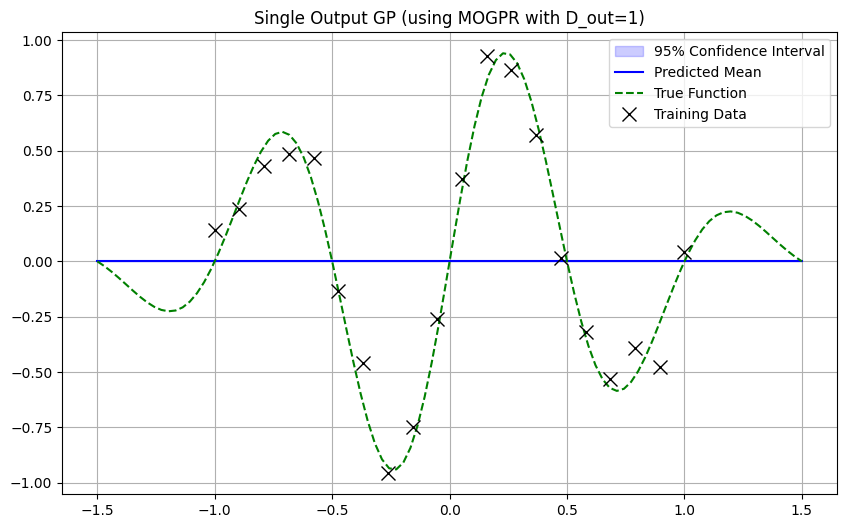

Learned lengthscale (log): tensor([4.5527])
Learned noise (log): tensor([-1.3210])
Learned B matrix:
 tensor([[8.9640e-11]])


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 3. 単一出力GP (D_out = 1) のデモ
# -----------------------------------------------------------------------------

print("\n--- Demo: Single Output GP (D_out=1) ---")

# --- 1. データの生成 ---
D_in_single = 1
D_out_single = 1

def f_single(x):
    return torch.sin(x * 2 * math.pi) * torch.exp(-x**2)

N_train_single = 20
# Xは [N, D_in]
X_train_s = torch.linspace(-1, 1, N_train_single).reshape(-1, D_in_single)
# Iは [N]。すべてタスク0（唯一のタスク）
I_train_s = torch.zeros(N_train_single, dtype=torch.long)
# Yは [N, 1]
Y_train_s = f_single(X_train_s) + torch.randn_like(X_train_s) * 0.1

N_test_single = 100
X_test_s = torch.linspace(-1.5, 1.5, N_test_single).reshape(-1, D_in_single)
I_test_s = torch.zeros(N_test_single, dtype=torch.long)
Y_test_s_true = f_single(X_test_s)

# --- 2. モデルの初期化と学習 ---
# D_out=1, Q=1 (潜在次元は1で十分)
model_single = MOGPR(D_in=D_in_single, D_out=D_out_single, Q=1)

# 学習
model_single.fit(X_train_s, I_train_s, Y_train_s, steps=100, lr=0.1)

# --- 3. 予測 ---
mu_s, var_s = model_single.predict(X_test_s, I_test_s)

# --- 4. 結果の可視化 ---
mu_s = mu_s.squeeze().numpy()
var_s = var_s.squeeze().numpy()
std_s = np.sqrt(var_s)
X_test_s_np = X_test_s.squeeze().numpy()

plt.figure(figsize=(10, 6))
plt.title("Single Output GP (using MOGPR with D_out=1)")
# 95%信頼区間
plt.fill_between(X_test_s_np, mu_s - 1.96 * std_s, mu_s + 1.96 * std_s, 
                 alpha=0.2, color='blue', label='95% Confidence Interval')
# 予測平均
plt.plot(X_test_s_np, mu_s, 'b-', label='Predicted Mean')
# 真の関数
plt.plot(X_test_s_np, Y_test_s_true.squeeze().numpy(), 'g--', label='True Function')
# 学習データ
plt.plot(X_train_s.squeeze().numpy(), Y_train_s.squeeze().numpy(), 'kx', 
         markersize=10, label='Training Data')
plt.legend()
plt.grid(True)
plt.show()

# 学習されたハイパーパラメータの確認
print("Learned lengthscale (log):", model_single.log_lengthscale.data)
print("Learned noise (log):", model_single.log_noises.data)
# B行列 (1x1) はRBFカーネルの振幅(signal variance)に相当
print("Learned B matrix:\n", model_single._build_B().data)


--- Demo: Multi Output GP (D_out=2) ---
--- Optimizing MOGPR ---
Step 000/40 - NLML: 59.8227
Step 010/40 - NLML: -24.9743
Step 020/40 - NLML: -24.9743
Step 030/40 - NLML: -24.9743
--- Optimization finished ---


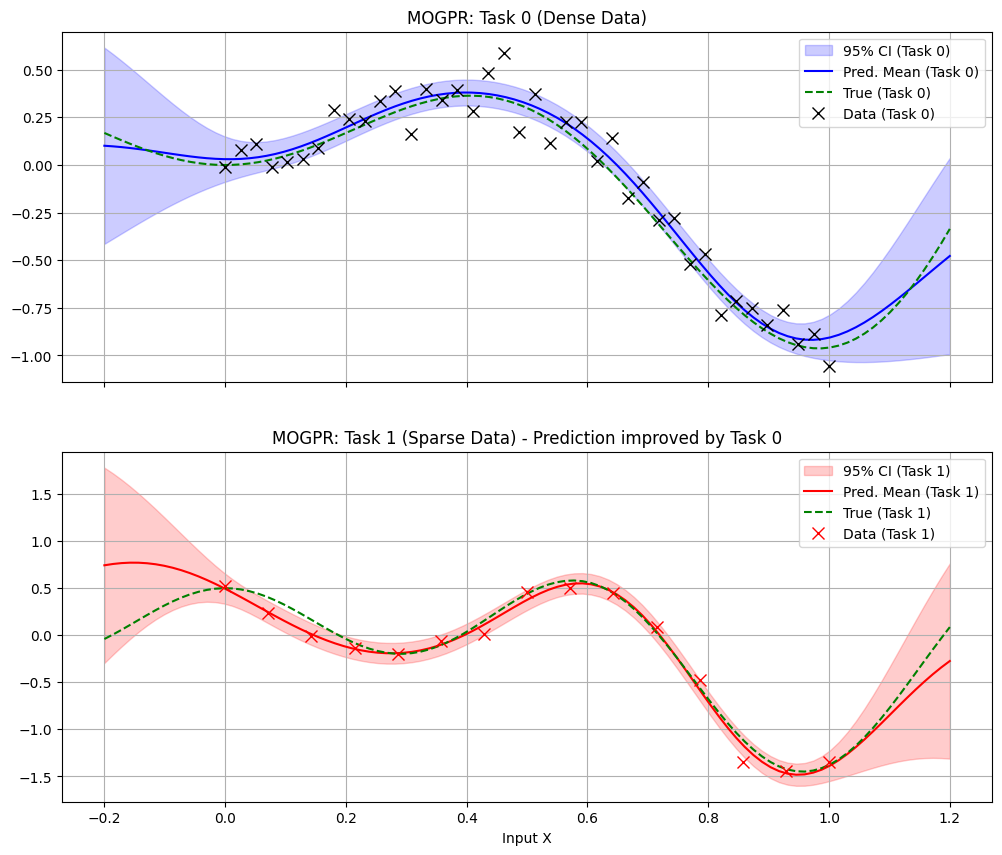

Learned B matrix (Output correlations):
 tensor([[0.1705, 0.2563],
        [0.2563, 0.8518]])
Learned Noises (log): tensor([-4.6327, -4.7963])


In [3]:
# -----------------------------------------------------------------------------
# 4. マルチ出力GP (D_out = 2) のデモ
# -----------------------------------------------------------------------------
print("\n--- Demo: Multi Output GP (D_out=2) ---")

# --- 1. データの生成 (2つの相関する関数) ---
D_in_multi = 1
D_out_multi = 2

# 真の関数
def f_multi_1(x):
    return torch.sin(x * 5) * x

def f_multi_2(x):
    return torch.sin(x * 5) * x + torch.cos(x * 10) * 0.5

# タスク1 (f1) のデータ (密)
N1 = 40
X1 = torch.linspace(0, 1, N1).reshape(-1, D_in_multi)
I1 = torch.zeros(N1, dtype=torch.long) # タスク0
Y1 = f_multi_1(X1) + torch.randn_like(X1) * 0.1

# タスク2 (f2) のデータ (疎)
N2 = 15
X2 = torch.linspace(0, 1, N2).reshape(-1, D_in_multi)
I2 = torch.ones(N2, dtype=torch.long) # タスク1
Y2 = f_multi_2(X2) + torch.randn_like(X2) * 0.1

# データを結合 (MOGPRの入力形式)
X_train_m = torch.cat([X1, X2], dim=0)
I_train_m = torch.cat([I1, I2], dim=0)
Y_train_m = torch.cat([Y1, Y2], dim=0)

# --- 2. モデルの初期化と学習 ---
# D_out=2, Q=2 (潜在次元を2に設定)
model_multi = MOGPR(D_in=D_in_multi, D_out=D_out_multi, Q=2)

# 学習
model_multi.fit(X_train_m, I_train_m, Y_train_m, steps=40, lr=0.1)

# --- 3. 予測 ---
N_test_multi = 100
X_test_m = torch.linspace(-0.2, 1.2, N_test_multi).reshape(-1, D_in_multi)

# タスク0 (f1) の予測
I_test_m0 = torch.zeros(N_test_multi, dtype=torch.long)
mu_m0, var_m0 = model_multi.predict(X_test_m, I_test_m0)

# タスク1 (f2) の予測
I_test_m1 = torch.ones(N_test_multi, dtype=torch.long)
mu_m1, var_m1 = model_multi.predict(X_test_m, I_test_m1)

# --- 4. 結果の可視化 ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
X_test_m_np = X_test_m.squeeze().numpy()

# タスク0 (f1) のプロット
mu_m0, var_m0 = mu_m0.squeeze().numpy(), var_m0.squeeze().numpy()
std_m0 = np.sqrt(var_m0)
ax1.fill_between(X_test_m_np, mu_m0 - 1.96 * std_m0, mu_m0 + 1.96 * std_m0, 
                 alpha=0.2, color='blue', label='95% CI (Task 0)')
ax1.plot(X_test_m_np, mu_m0, 'b-', label='Pred. Mean (Task 0)')
ax1.plot(X_test_m_np, f_multi_1(X_test_m).squeeze().numpy(), 'g--', label='True (Task 0)')
ax1.plot(X1.squeeze().numpy(), Y1.squeeze().numpy(), 'kx', markersize=8, label='Data (Task 0)')
ax1.set_title("MOGPR: Task 0 (Dense Data)")
ax1.legend()
ax1.grid(True)

# タスク1 (f2) のプロット
mu_m1, var_m1 = mu_m1.squeeze().numpy(), var_m1.squeeze().numpy()
std_m1 = np.sqrt(var_m1)
ax2.fill_between(X_test_m_np, mu_m1 - 1.96 * std_m1, mu_m1 + 1.96 * std_m1, 
                 alpha=0.2, color='red', label='95% CI (Task 1)')
ax2.plot(X_test_m_np, mu_m1, 'r-', label='Pred. Mean (Task 1)')
ax2.plot(X_test_m_np, f_multi_2(X_test_m).squeeze().numpy(), 'g--', label='True (Task 1)')
ax2.plot(X2.squeeze().numpy(), Y2.squeeze().numpy(), 'rx', markersize=8, label='Data (Task 1)')
ax2.set_title("MOGPR: Task 1 (Sparse Data) - Prediction improved by Task 0")
ax2.legend()
ax2.grid(True)
plt.xlabel("Input X")
plt.show()

# 学習された共地域化行列 B の確認
print("Learned B matrix (Output correlations):\n", model_multi._build_B().data)
print("Learned Noises (log):", model_multi.log_noises.data)

In [8]:
len(X1), len(X2)

(40, 15)

In [10]:
X_train_m.shape

torch.Size([55, 1])

In [12]:
I_train_m.shape

torch.Size([55])

In [19]:
import torch

# -----------------------------------------------------------------------------
# 1. RBFカーネル (入力間 k(x, x'))
# -----------------------------------------------------------------------------
def rbf_kernel(X1, X2, lengthscale):
    """
    入力間のRBFカーネル
    Args:
        X1 (torch.Tensor): [N1, D_in]
        X2 (torch.Tensor): [N2, D_in]
        lengthscale (torch.Tensor): [D_in]
    """
    X1_scaled = X1 / lengthscale
    X2_scaled = X2 / lengthscale
    sq_dist = torch.sum(X1_scaled**2, dim=1, keepdim=True) - \
              2 * (X1_scaled @ X2_scaled.T) + \
              torch.sum(X2_scaled**2, dim=1, keepdim=True).T
    sq_dist = torch.clamp(sq_dist, min=0.0)
    return torch.exp(-0.5 * sq_dist)

# -----------------------------------------------------------------------------
# 2. 共地域化行列 B の構築 (ダミー)
# -----------------------------------------------------------------------------
def _build_B(D_out, Q, coreg_W, log_coreg_kappa):
    """
    B = W W^T + diag(kappa) を計算
    Args:
        D_out (int): 出力次元
        Q (int): 潜在次元
        coreg_W (torch.Tensor): [D_out, Q]
        log_coreg_kappa (torch.Tensor): [D_out]
    """
    kappa = torch.exp(log_coreg_kappa)
    B = coreg_W @ coreg_W.T + torch.diag(kappa)
    return B

# -----------------------------------------------------------------------------
# 3. メインの共分散行列構築 (ICM)
# -----------------------------------------------------------------------------
def _build_full_cov(X1, I1, X2, I2, lengthscale, B):
    """
    ICMの共分散行列 K((X1, I1), (X2, I2)) を計算
    K_ij = k(x_i, x_j) * B(i_i, i_j)
    
    Args:
        X1 (torch.Tensor): [N1, D_in]
        I1 (torch.Tensor): [N1] (long型インデックス)
        X2 (torch.Tensor): [N2, D_in]
        I2 (torch.Tensor): [N2] (long型インデックス)
        lengthscale (torch.Tensor): [D_in]
        B (torch.Tensor): [D_out, D_out] (共地域化行列)
    """
    
    # 1. 入力間カーネル k(X1, X2) -> (N1, N2)
    K_xx = rbf_kernel(X1, X2, lengthscale)
    
    # 2. 出力間カーネル B(I1, I2) -> (N1, N2)
    #    I1 と I2 を使って B から対応する相関を抜き出す
    #    B[I1, :] -> (N1, D_out)
    #    B[I1, :][:, I2] -> (N1, N2)
    #    (i, j)要素は B[I1[i], I2[j]] となる

    print(f"I1: {I1}")
    print(f"I2: {I2}")
    print(f"B[I1, :]: {B[I1, :]}")
    print(f"B[:, I2]: {B[:, I2]}")
    print(f"B[I1, :][:, I2]: {B[I1, :][:, I2]}")

    K_bb = B[I1, :][:, I2]
    
    # 3. 要素ごとの積 (アダマール積)
    K = K_xx * K_bb
    
    return K, K_xx, K_bb

# -----------------------------------------------------------------------------
# 4. サンプル実行
# -----------------------------------------------------------------------------
# --- パラメータ設定 ---
D_in = 1
D_out = 2 # 2つのタスク (タスク0, タスク1)
Q = 1     # 潜在次元

# --- サンプルハイパーパラメータ (通常は学習で得る) ---
# B = W W^T + kappa
# 例: W = [[1.0], [0.5]], kappa = [0.1, 0.1]
coreg_W = torch.tensor([[1.0], [0.5]])
log_coreg_kappa = torch.log(torch.tensor([0.1, 0.1]))

# B行列 (タスク間の相関)
B = _build_B(D_out, Q, coreg_W, log_coreg_kappa)
# B = [[1.0*1.0+0.1, 1.0*0.5],    -> [[1.1, 0.5],
#      [0.5*1.0,     0.5*0.5+0.1]]   ->  [0.5, 0.35]]

# RBFカーネルの長さスケール
lengthscale = torch.tensor([0.5]) # [D_in]

# --- サンプルデータ (N=3) ---
# 入力 X (3点)
X_train = torch.tensor([[0.1], [0.5], [0.9]]) # [N, D_in]

# タスクインデックス I (3点)
# 1点目: タスク0
# 2点目: タスク1
# 3点目: タスク0
I_train = torch.tensor([0, 1, 0])             # [N]

print("--- 入力データ ---")
print(f"X_train (N=3, D_in=1):\n{X_train}")
print(f"I_train (N=3):\n{I_train}")
print(f"B (D_out=2, D_out=2):\n{B}")

# --- 共分散行列の計算 ---
K, K_xx, K_bb = _build_full_cov(X_train, I_train, X_train, I_train, lengthscale, B)

print("\n--- 計算プロセス ---")

print(f"1. 入力間カーネル k(X, X) [K_xx]:\n{K_xx.round(decimals=3)}")
print("   (X間の距離のみに基づく)")

print(f"\n2. 出力間カーネル B(I, I) [K_bb]:")
print("   (I = [0, 1, 0] を使って B から抽出)")
print(f"{K_bb.round(decimals=3)}")
print("   (例: (0,1)要素は B[I[0], I[1]] = B[0, 1] = 0.5)")
print("   (例: (0,2)要素は B[I[0], I[2]] = B[0, 0] = 1.1)")
print("   (例: (1,1)要素は B[I[1], I[1]] = B[1, 1] = 0.35)")


print(f"\n3. 最終的な共分散行列 K = K_xx * K_bb:\n{K.round(decimals=3)}")

--- 入力データ ---
X_train (N=3, D_in=1):
tensor([[0.1000],
        [0.5000],
        [0.9000]])
I_train (N=3):
tensor([0, 1, 0])
B (D_out=2, D_out=2):
tensor([[1.1000, 0.5000],
        [0.5000, 0.3500]])
I1: tensor([0, 1, 0])
I2: tensor([0, 1, 0])
B[I1, :]: tensor([[1.1000, 0.5000],
        [0.5000, 0.3500],
        [1.1000, 0.5000]])
B[:, I2]: tensor([[1.1000, 0.5000, 1.1000],
        [0.5000, 0.3500, 0.5000]])
B[I1, :][:, I2]: tensor([[1.1000, 0.5000, 1.1000],
        [0.5000, 0.3500, 0.5000],
        [1.1000, 0.5000, 1.1000]])

--- 計算プロセス ---
1. 入力間カーネル k(X, X) [K_xx]:
tensor([[1.0000, 0.7260, 0.2780],
        [0.7260, 1.0000, 0.7260],
        [0.2780, 0.7260, 1.0000]])
   (X間の距離のみに基づく)

2. 出力間カーネル B(I, I) [K_bb]:
   (I = [0, 1, 0] を使って B から抽出)
tensor([[1.1000, 0.5000, 1.1000],
        [0.5000, 0.3500, 0.5000],
        [1.1000, 0.5000, 1.1000]])
   (例: (0,1)要素は B[I[0], I[1]] = B[0, 1] = 0.5)
   (例: (0,2)要素は B[I[0], I[2]] = B[0, 0] = 1.1)
   (例: (1,1)要素は B[I[1], I[1]] = B[1, 1] = 0.35)



In [14]:
K

tensor([[1.1000, 0.3631, 0.3058],
        [0.3631, 0.3500, 0.3631],
        [0.3058, 0.3631, 1.1000]])

In [15]:
K_xx

tensor([[1.0000, 0.7261, 0.2780],
        [0.7261, 1.0000, 0.7261],
        [0.2780, 0.7261, 1.0000]])

In [16]:
K_bb

tensor([[1.1000, 0.5000, 1.1000],
        [0.5000, 0.3500, 0.5000],
        [1.1000, 0.5000, 1.1000]])